The first chunk loads and formats all the relevant data. To switch between the fashion and the digit dataset, adjust the "dataset" variable. To summarize the shirts and t-shirts for the two-step neural network, adjust the "summarize_shirt" variable.

In [3]:
import numpy as np
import pandas as pnd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import os
import seaborn as sns

from PIL import Image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix

#load data
dataset = 1
match dataset:
    case 1:
        test = 'fashion-mnist_test.csv'
        train = 'fashion-mnist_train.csv'
    case 2: 
        test = "mnist_test.csv"
        train = "mnist_train.csv"
testdata = pnd.read_csv(test)
traindata = pnd.read_csv(train)

#split into images and labels
testdata_pixel = testdata.drop(testdata.columns[0], axis=1).to_numpy()
traindata_pixel = traindata.drop(traindata.columns[0], axis=1).to_numpy()
label_train = traindata[traindata.columns[0]].to_numpy()
label_test = testdata[testdata.columns[0]].to_numpy()
og_label_train = label_train.copy()
og_label_test = label_test.copy()

#reshape for cnn
cnn_test = testdata_pixel.reshape(-1,28,28) /255.0
cnn_train = traindata_pixel.reshape(-1,28,28) /255.0
cnn_test = np.expand_dims(cnn_test,axis=3)
cnn_train = np.expand_dims(cnn_train,axis=3)
cnn_label_test = tf.keras.utils.to_categorical(label_test)
cnn_label_train = tf.keras.utils.to_categorical(label_train)

softmax_nodes = 10
class_names = np.array(["T-shirt / Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])

#summarize the classes 0 and 6
summarize_shirt = False
if summarize_shirt == True:
    label_test[label_test==6]=0
    label_test[label_test>=7]-=1
    label_train[label_train==6]=0
    label_train[label_train>=7]-=1
    cnn_label_test = tf.keras.utils.to_categorical(label_test)
    cnn_label_train = tf.keras.utils.to_categorical(label_train)
    softmax_nodes -= 1
    class_names = np.delete(class_names,6)

    shirts_pixel = traindata_pixel[(og_label_train==6)|(og_label_train==0)]
    shirts_pixel = shirts_pixel.reshape(-1,28,28) /255.0
    shirts_pixel = np.expand_dims(shirts_pixel,axis=3)
    label_shirts = og_label_train[(og_label_train==6)|(og_label_train==0)]
    label_shirts[label_shirts==6]=1
    label_shirts = tf.keras.utils.to_categorical(label_shirts)

    shirts_pixel_val = testdata_pixel[(og_label_test==6)|(og_label_test==0)]
    shirts_pixel_val = shirts_pixel_val.reshape(-1,28,28) /255.0
    shirts_pixel_val = np.expand_dims(shirts_pixel_val,axis=3)
    label_shirts_val = og_label_test[(og_label_test==6)|(og_label_test==0)].copy()
    label_shirts_val[label_shirts_val==6]=1
    label_shirts_val = tf.keras.utils.to_categorical(label_shirts_val)


The following chunk allows to load custom images by adjusting the filepath of the variable "your_image". The image is then converted to grayscale and classified using our most complex cnn model. The current default is an image of the beloved character "Bernd das Brot".

1/1 [==============================] - 0s 297ms/step
T-shirt / Top: 0.089
Trouser: 0.0
Pullover: 0.007
Dress: 0.0
Coat: 0.0
Sandal: 0.0
Shirt: 0.896
Sneaker: 0.0
Bag: 0.007
Ankle Boot: 0.0


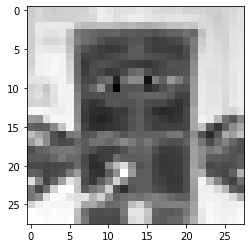

1/1 [==============================] - 0s 269ms/step
T-shirt / Top: 0.002
Trouser: 0.0
Pullover: 0.002
Dress: 0.005
Coat: 0.004
Sandal: 0.009
Shirt: 0.022
Sneaker: 0.0
Bag: 0.955
Ankle Boot: 0.001


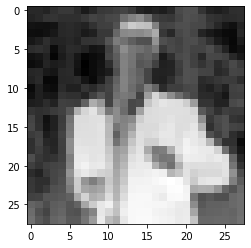

In [12]:
def convert_image_to_grayscale(image_path):
    image = Image.open(image_path).convert('L')
    resized_image = image.resize((28, 28))
    numpy_image = np.array(resized_image)
    normalized_image = (numpy_image / np.max(numpy_image)) * -255
    final_image = normalized_image.astype(np.uint8)
    return final_image
def display_image(filepath="Report/Plots/bernd.jpg"):
    your_image = convert_image_to_grayscale(filepath)
    plt.imshow(your_image,cmap="gray")
    #plt.savefig('Report/Plots/bernd.svg',format="svg")
    your_image = your_image.reshape(-1,28,28) / 255.0
    your_image = np.expand_dims(your_image,axis=3)
    model = tf.keras.models.load_model('Results/model_shirts_notsum')
    for i,prob in enumerate(np.round(model.predict(your_image)[0],3)):
        print(str(class_names[i])+": " + str(prob))
display_image()
plt.show()
display_image("Report/Plots/nggyu.jpg")

We have now loaded and reshaped the data. The labels were converted into 10-dimensional to be compatible with the output of the softmax activation function and the dimension of the images was increased by one to show that there is only one color channel. 

In [ ]:
lenet5_model = Sequential([
  Conv2D(6, 5, input_shape=(28, 28, 1), activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  Conv2D(16, 5, activation="relu",padding="valid"),
  MaxPooling2D(pool_size=2,strides=2),
  Conv2D(120, 5, activation="relu",padding="valid"),
  Flatten(),
  Dense(84,activation="relu"),
  Dense(softmax_nodes, activation='softmax'),
])
lenet5_model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)
lenet5_model.fit(
  cnn_train,
  cnn_label_train,
  epochs=20,
  validation_data=(cnn_test, cnn_label_test)
)

The previous code used a modifyed LeNet-5 architecture with max pooling instead of mean pooling and ReLU activation. The next two chunks allow to train two slightly different modified versions of the VGG architecture.

In [ ]:
vgg_model = Sequential([
  Conv2D(32, 3, input_shape=(28, 28, 1), activation="relu",padding="same"),
  Conv2D(32, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  BatchNormalization(),
  Conv2D(16, 3, activation="relu",padding="same"),
  Conv2D(16, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  BatchNormalization(),
  Conv2D(16, 3, activation="relu",padding="same"),
  Conv2D(16, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  BatchNormalization(),
  Conv2D(16, 3, activation="relu",padding="same"),
  Conv2D(16, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=1),
  BatchNormalization(),
  Conv2D(16, 3, activation="relu",padding="same"),
  Conv2D(16, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=1),
  BatchNormalization(),
  Flatten(),
  Dense(256,activation="relu"),
  Dropout(0.15),
  Dense(256,activation="relu"),
  Dropout(0.15),
  Dense(softmax_nodes, activation='softmax'),
])
vgg_model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)
vgg_model.fit(
  cnn_train,
  cnn_label_train,
  epochs=20,
  validation_data=(cnn_test, cnn_label_test),
  batch_size=128
)

In [ ]:
complex_model = Sequential([
  Conv2D(16, 5, input_shape=(28, 28, 1), activation="relu",padding="same"),
  Conv2D(16, 5, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  BatchNormalization(),
  Conv2D(32, 3, activation="relu",padding="same"),
  Conv2D(32, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  BatchNormalization(),
  Conv2D(64, 3, activation="relu",padding="same"),
  Conv2D(64, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  BatchNormalization(),
  Conv2D(64, 3, activation="relu",padding="same"),
  Conv2D(64, 3, activation="relu",padding="same"),
  Conv2D(64, 3, activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=1),
  BatchNormalization(),
  Flatten(),
  Dense(256,activation="relu"),
  Dropout(0.1),
  Dense(512,activation="relu"),
  Dropout(0.1),
  Dense(softmax_nodes, activation='softmax'),
])
complex_model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)
tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.01,
    patience=2,
    verbose=0,
    mode='auto',
    restore_best_weights=True,
    start_from_epoch=0
)
history = complex_model.fit(
  cnn_train,
  cnn_label_train,
  epochs = 5,
  validation_data=(cnn_test, cnn_label_test),
  batch_size=256
)

The following chunk allows to load a model of your choice and create the modifyed confusion matrix as described in the report and show the architecture using the visualkeras package.

In [ ]:
model = tf.keras.models.load_model('Results/complex_model')
y_pred = model.predict(cnn_test)
y_pred = np.argmax(y_pred,axis=1)
conf = sklearn.metrics.confusion_matrix(y_pred, label_test)
conf_df = pnd.DataFrame(conf, index=class_names, columns=class_names)
rowsums = conf_df.sum(axis=1)
acc = np.sum(y_pred == label_test)/ len(label_test)
for i in range(len(conf_df)):
    for j in range(len(conf_df.columns)):
        if i != j:
            conf_df.values[i,j] -= (1-acc)*rowsums[i]/(len(conf_df)-1)
        else: 
            conf_df.values[i,j] -= acc*rowsums[i]
sns.heatmap(conf_df, annot=True, cmap= "RdBu", annot_kws={"fontsize":6},fmt=",.1f",center=0)
import visualkeras 
visualkeras.layered_view(model)

The following two chunks train a model that only distinguishes between shirts and t-shirts and to then make predictions using the two-stage model.

In [ ]:
lenet5_shirt_model = Sequential([
  Conv2D(6, 5, input_shape=(28, 28, 1), activation="relu",padding="same"),
  MaxPooling2D(pool_size=2,strides=2),
  Conv2D(16, 5, activation="relu",padding="valid"),
  MaxPooling2D(pool_size=2,strides=2),
  Conv2D(120, 5, activation="relu",padding="valid"),
  Flatten(),
  Dense(84,activation="relu"),
  Dense(2, activation='softmax'),
])
lenet5_shirt_model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)
lenet5_shirt_model.fit(
  shirts_pixel,
  label_shirts,
  epochs=75,
  validation_data = (shirts_pixel_val,label_shirts_val),
  batch_size = 256
)

In [ ]:
model_shirts_sum = model.load("Results/model_shirts_sum/")
predictions = model_shirts_sum.predict(cnn_test)
predictions =np.argmax(predictions, axis=1)
predictions[predictions>=6]+=1
prediction_shirt = cnn_test[predictions==0]
prediction_shirt_final = lenet5_shirt_model.predict(prediction_shirt)
prediction_shirt_final = np.argmax(prediction_shirt_final,axis=1) 
index = np.where(predictions==0)[0]
for i in range(np.sum(predictions==0)):
    if prediction_shirt_final[i]==1:
        predictions[index[i]] = 6
print(np.sum(predictions==og_label_test)/len(og_label_test))
print(np.sum(predictions==6))
y_pred = predictions
y_true = og_label_test 
class_names = np.array(["T-shirt / Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
conf = confusion_matrix(y_pred, y_true)
conf_df = pnd.DataFrame(conf, index=class_names, columns=class_names)
print(conf_df)
sns.heatmap(conf_df, annot=True, cmap='RdYlGn')